Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [53]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [225]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv', parse_dates=['SALE DATE'], index_col='SALE DATE')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [226]:

df['BOROUGH'] = df['BOROUGH'].astype(str)
df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)

In [227]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index


df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [228]:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000)]

In [229]:
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '')
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(int)


In [230]:
df['EASE-MENT'] = df['EASE-MENT'].fillna(0)

In [231]:
target = 'SALE_PRICE'
y = df[target]
X = df.drop([target]+['ADDRESS', 'APARTMENT_NUMBER','BUILDING_CLASS_CATEGORY','ZIP_CODE'], axis=1)

In [232]:

cutoff = '2019-04-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [233]:
assert X_train.shape[0] + X_val.shape[0] == X.shape[0]

In [234]:
y_train.mean()

621573.7423214999

In [235]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE:', mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))

Baseline MAE: 214721.52773001452


In [236]:
from sklearn.linear_model import LinearRegression

# NOTE that we are using a different library for our encoder
from category_encoders import OneHotEncoder

In [237]:
X_train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [240]:
transformer_1 = OneHotEncoder(use_cat_names=True, cols=['BOROUGH','NEIGHBORHOOD','TAX_CLASS_AT_PRESENT','BUILDING_CLASS_AT_PRESENT','TAX_CLASS_AT_TIME_OF_SALE','BUILDING_CLASS_AT_TIME_OF_SALE'])

In [241]:
transformer_1.fit(X_train)

OneHotEncoder(cols=['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT',
                    'BUILDING_CLASS_AT_PRESENT', 'TAX_CLASS_AT_TIME_OF_SALE',
                    'BUILDING_CLASS_AT_TIME_OF_SALE'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [242]:
XT_train = transformer_1.transform(X_train)

In [243]:
XT_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE_1.0,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
SALE DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5495,801,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,6800,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
2019-01-01,0,1,0,0,0,1,0,0,0,0,0,0,1,0,7918,72,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,4000,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,0,0,1,0,0,1,0,0,0,0,0,0,1,0,4210,19,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,3500,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5212,69,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,4000,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7930,121,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,1710,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4081,44,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,1.0,2400,921.0,1950.0,1,0,0,0,0,1,0,0,0,0,0,0
2019-03-29,0,0,0,1,0,1,0,0,0,0,0,0,1,0,2373,201,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,2450,2128.0,1980.0,1,0,0,1,0,0,0,0,0,0,0,0
2019-03-29,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1132,42,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,4361,1807.0,2018.0,1,0,1,0,0,0,0,0,0,0,0,0


In [244]:
from sklearn.feature_selection import SelectKBest

In [245]:

transformer_2 = SelectKBest(k=10) 

transformer_2.fit(XT_train, y_train)

XTT_train = transformer_2.transform(XT_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 4 16 28 29 36 47] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [246]:
predictor = LinearRegression()

predictor.fit(XTT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:

y_pred = predictor.predict(XTT_train)


print('Training MAE:', mean_absolute_error(y_train, y_pred))

Training MAE: 204574.32746055152


In [248]:

XT_val = transformer_1.transform(X_val)
XTT_val = transformer_2.transform(XT_val)


y_pred = predictor.predict(XTT_val)


print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 205381.5281206536


In [249]:
from sklearn.linear_model import Ridge


predictor_2 = Ridge(alpha=0.2) 

# Fit to training data
predictor_2.fit(XTT_train, y_train)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [250]:

y_pred = predictor_2.predict(XTT_train)

# Calculate MAE
print('Training MAE:', mean_absolute_error(y_train, y_pred))

Training MAE: 204160.19736964002


In [251]:

XT_val = transformer_1.transform(X_val)
XTT_val = transformer_2.transform(XT_val)

# Make predictions (TRANSFOMED validation data)
y_pred = predictor_2.predict(XTT_val)

print('Training MAE:', mean_absolute_error(y_val, y_pred))

Training MAE: 204761.2566921096


In [252]:
from sklearn.preprocessing import StandardScaler


transformer_1 = OneHotEncoder(use_cat_names=True)
XT_train = transformer_1.fit_transform(X_train)


transformer_2 = StandardScaler()
XTT_train = transformer_2.fit_transform(XT_train)


predictor = Ridge(normalize=True)
predictor.fit(XTT_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

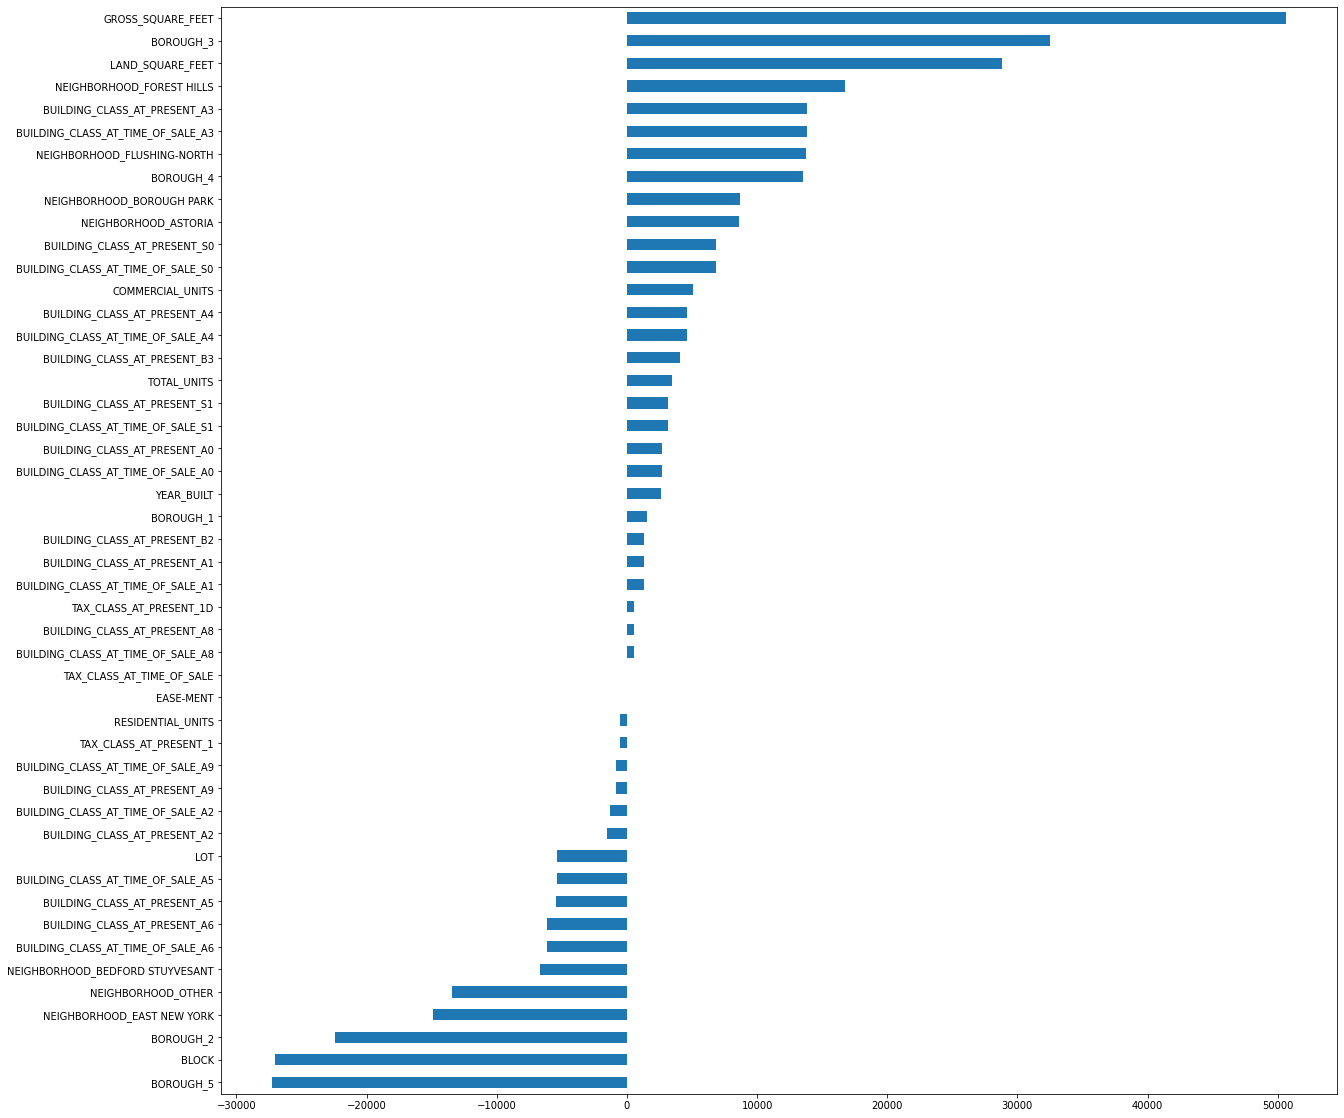

In [256]:
pd.Series(predictor.coef_, index=XT_train.columns).sort_values().plot(kind='barh', figsize=(20,20))